# Data Analysis Project  
### Master's Degree in Quantitative Biology  
**University of Milan**  
**This Analysis has been done as a part of the course "Measurement of nanoscale interactions in biological systems and data analysis"**

---

## Estimation of Ionic Strength from Electrostatic Double Layer Interaction

### Summary

In this exercise, the ionic strength $I$ of an electrolyte solution is estimated from atomic force microscopy (AFM) measurements of electrostatic double layer interactions.

For monovalent salts such as NaCl dissolved in water, the Debye length $\lambda_D$ (the screening length of the electrostatic double layer) relates to ionic strength through:

$$
\lambda_D \, (\text{nm}) = \frac{0.304}{\sqrt{I \, (\text{M})}}
$$

where $I$ is the ionic strength in mol/L.

The Debye length $\lambda_D$ is extracted by fitting a force vs distance curve using the model:

$$
F(d) = F_0 + a d + c \, e^{-d/\lambda_D}
$$

- $d$: tip-sample distance (nm)  
- $F_0 + a d$: linear instrumental baseline  
- $c$: scaling factor  
- $\lambda_D$: Debye length

---

### Objective

Extract $\lambda_D$ from the force-distance curve and compute the ionic strength $I$ in mol/L with its uncertainty.

---

### Tasks

- Load data from `FC_DLVO_with_baseline.txt` (columns: distance [nm], force [nN], force error [nN])
- Plot the force curve with error bars
- Estimate initial values for fit parameters ($\lambda_D$, $c$, $F_0$, $a$); justify the method
- Perform a weighted nonlinear fit to extract $\lambda_D$ and its error
- Plot residuals $\Delta = F - F_{\text{fit}}$ vs distance
- Estimate $I$ and its error using the fitted $\lambda_D$

---


### Step 1: Import libraries and load data

In [2]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
from scipy.optimize import curve_fit

In [16]:
# Load data
file_path = "FC_DLVO_with_baseline.txt"  
column_names = ["Distance_nm", "Force_nN", "ForceError_nN"]
df = pd.read_csv(file_path, delim_whitespace=True, names=column_names)

# Convert all to numeric and check for missing values
df = df.apply(pd.to_numeric, errors='coerce')
print("Missing values in each column:")
print(df.isnull().sum())

# Display basic statistics
print("\nSummary statistics:")
print(df.describe())


Missing values in each column:
Distance_nm      0
Force_nN         0
ForceError_nN    0
dtype: int64

Summary statistics:
       Distance_nm     Force_nN  ForceError_nN
count  1022.000000  1022.000000    1022.000000
mean    277.702568     0.837808       0.064878
std     147.585969     0.348163       0.057633
min      21.597983     0.290819       0.000051
25%     150.051480     0.524461       0.021329
50%     277.709645     0.820121       0.048782
75%     405.343077     1.134213       0.090865
max     532.925750     1.464235       0.336755


### Step 2: Plotting Force Curve with Error Bars

We visualize the experimental data to observe the overall trend in the measured forces as a function of tip-sample distance. Error bars represent the uncertainty in the force measurements provided in the dataset.


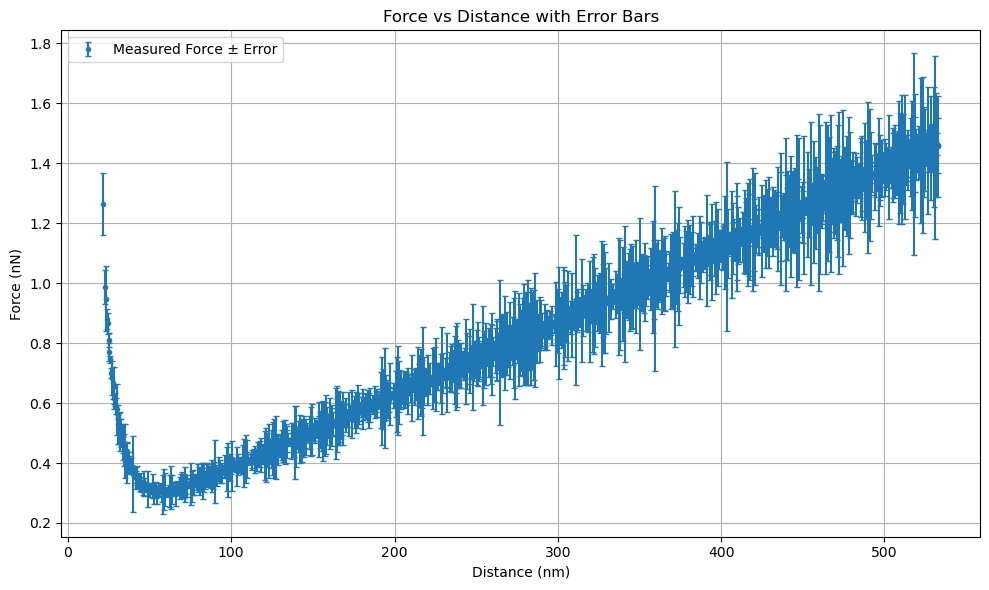

In [25]:
# Plot the force vs distance curve with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(df["Distance_nm"], df["Force_nN"], yerr=df["ForceError_nN"],
             fmt='o', markersize=3, capsize=2, label='Measured Force ± Error')

plt.xlabel("Distance (nm)")
plt.ylabel("Force (nN)")
plt.title("Force vs Distance with Error Bars")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Step 3: Estimating Initial Values for Model Parameters

To fit the force-distance data to the model

$$
F(d) = F_0 + a d + c e^{-d/\lambda_D}
$$

we need initial guesses for the parameters:

- **$F_0$ (baseline offset)**: estimated from a linear fit to the high-distance tail of the data.
- **$a$ (slope of linear baseline)**: same linear fit.
- **$c$ (exponential amplitude)**: estimated from the difference between the peak force and the baseline at the shortest distance.
- **$\lambda_D$ (Debye length)**: guessed from typical values in electrolyte solutions (~10 nm for 1 mM NaCl).

These values provide the starting point for nonlinear curve fitting.


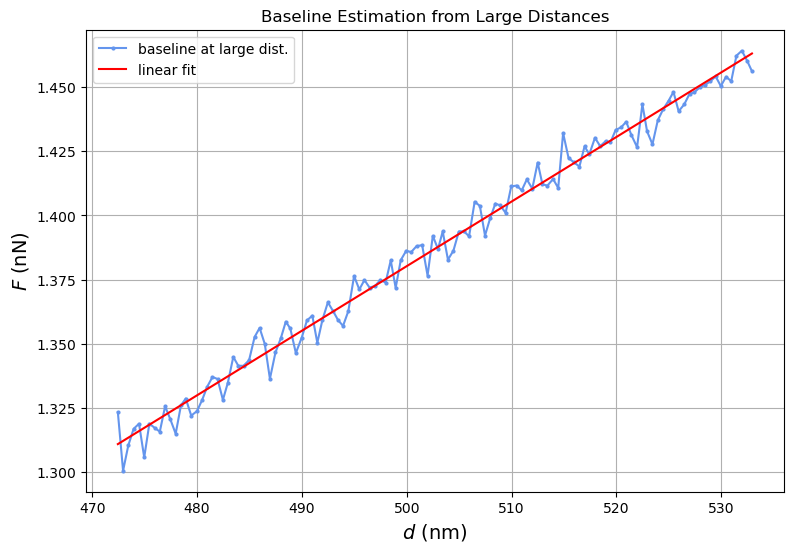

Selected interval for baseline fit: 900 to 1022
Initial guess for baseline parameters (a, f0): 0.0025 nN/nm 0.1208 nN


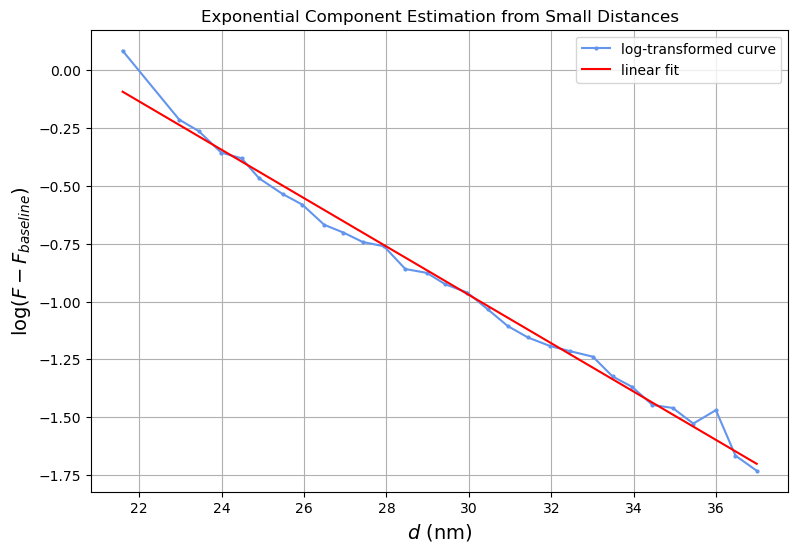

Selected interval for exponential fit: 0 to 30
Initial guess for DLVO parameters (lambda_D, c): 9.5590 nm 8.7324 nN


In [19]:
# Define models
def dlvofit(x, c, lD, a, f0):
    return a * x + f0 + c * np.exp(-x / lD)

def linearfit(x, a, f0):
    return a * x + f0

# Extract data
d = df["Distance_nm"].values
f = df["Force_nN"].values

# Estimate a and f0 from large distances
_from = 900
_to = len(d)
popt, _ = curve_fit(linearfit, d[_from:_to], f[_from:_to])
a0 = popt[0]
f00 = popt[1]

# Plot linear fit
plt.figure(figsize=(9,6))
plt.plot(d[_from:_to], f[_from:_to], label='baseline at large dist.', color='cornflowerblue', marker='o', markersize=2)
plt.plot(d[_from:_to], linearfit(d[_from:_to], a0, f00), label='linear fit', color='red')
plt.xlabel('$d$ (nm)', fontsize=14)
plt.ylabel('$F$ (nN)', fontsize=14)
plt.legend()
plt.title("Baseline Estimation from Large Distances")
plt.grid(True)
plt.show()

print('Selected interval for baseline fit:', _from, 'to', _to)
print('Initial guess for baseline parameters (a, f0):', f"{a0:.4f} nN/nm", f"{f00:.4f} nN")

# Estimate lambda_D and c from small distances
_from = 0
_to = 30
f_baseline = linearfit(d, a0, f00)
f_diff = f - f_baseline
f_diff_clipped = np.clip(f_diff, a_min=1e-9, a_max=None)  
f_log = np.log(f_diff_clipped)

# Linear fit to log data
popt, _ = curve_fit(linearfit, d[_from:_to], f_log[_from:_to])
lD0 = -1 / popt[0]
c0 = np.exp(popt[1])

# Plot log-linear fit
plt.figure(figsize=(9,6))
plt.plot(d[_from:_to], f_log[_from:_to], label='log-transformed curve', color='cornflowerblue', marker='o', markersize=2)
plt.plot(d[_from:_to], linearfit(d[_from:_to], popt[0], popt[1]), label='linear fit', color='red')
plt.xlabel('$d$ (nm)', fontsize=14)
plt.ylabel('$\log(F - F_{baseline})$', fontsize=14)
plt.legend()
plt.title("Exponential Component Estimation from Small Distances")
plt.grid(True)
plt.show()

print('Selected interval for exponential fit:', _from, 'to', _to)
print('Initial guess for DLVO parameters (lambda_D, c):', f"{lD0:.4f} nm", f"{c0:.4f} nN")

# Initial parameter vector for nonlinear fit: [c, lambda_D, a, f0]
p0 = [c0, lD0, a0, f00]


### Step 4: Nonlinear Fit of the DLVO Model (Weighted)

We now fit the full model:

$$
F(d) = F_0 + a d + c e^{-d/\lambda_D}
$$

using a **weighted nonlinear regression**:
- Weights = inverse of the squared force errors: $( w = \frac{1}{\sigma^2} )$
- This ensures that points with **lower measurement uncertainty** influence the fit more strongly.

We use `scipy.optimize.curve_fit` with the initial parameters estimated in Step 3.


<Figure size 640x480 with 0 Axes>

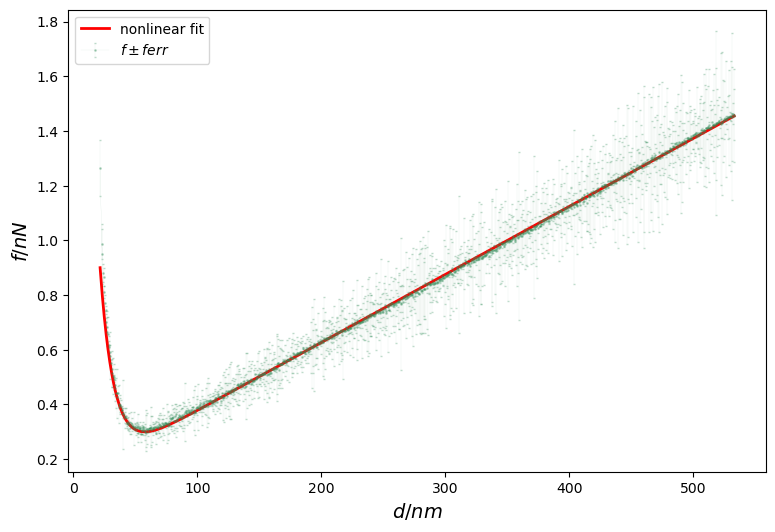

<Figure size 640x480 with 0 Axes>

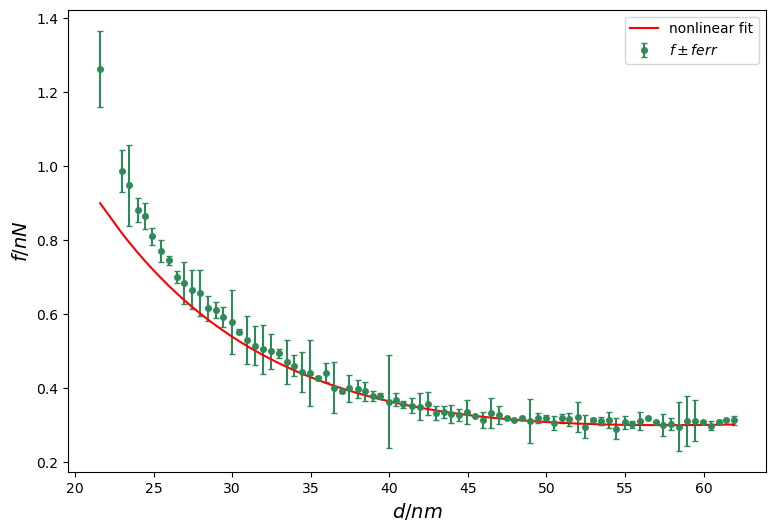

<Figure size 640x480 with 0 Axes>

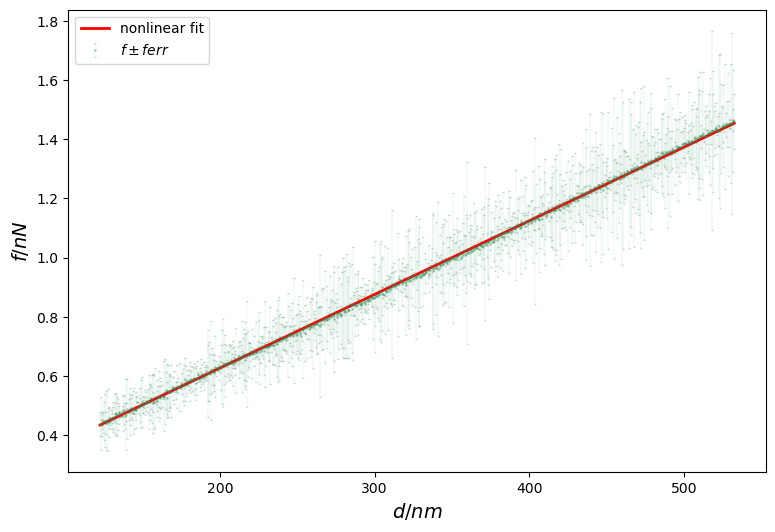

Best estimation of fit parameters (lD, c, a, f0): 11.0546 nm 5.062219203106538 nN 0.002488707607059934 nN/nm 0.12897707173855372 nN
lD = 11.0546 +/- 0.1539 nm


In [22]:
# Define the DLVO model
def dlvofit(x, c, lD, a, f0):
    return a * x + f0 + c * np.exp(-x / lD)

# Set up variables 
d = df["Distance_nm"].values
f = df["Force_nN"].values
ferr = df["ForceError_nN"].values
N = len(d)

# Weighted nonlinear fit 
popt, pcov = curve_fit(dlvofit, d, f, p0=p0, sigma=ferr)
perr = np.sqrt(np.diag(pcov))

# Extract fitted parameters
c = popt[0]
lD = popt[1]
lD_err = perr[1]
a = popt[2]
f0 = popt[3]

# Full range plot
plt.clf()
plt.figure(figsize=(9, 6))
plt.errorbar(d, f, yerr=ferr, capsize=1, color='seagreen', marker='o', markersize=1, label='$f \\pm ferr$', linewidth=0.1, alpha=0.3)
plt.plot(d, dlvofit(d, *popt), label='nonlinear fit', color='red', linestyle='solid', linewidth=2.0)
plt.xlabel('$d / nm$', fontsize=14)
plt.ylabel('$f / nN$', fontsize=14)
plt.legend()
plt.show()

# Zoomed plot: small distances
_from = 0
_to = 80
plt.clf()
plt.figure(figsize=(9, 6))
plt.errorbar(d[_from:_to], f[_from:_to], yerr=ferr[_from:_to], capsize=2, color='seagreen', marker='o', markersize=4, label='$f \\pm ferr$', linestyle='')
plt.plot(d[_from:_to], dlvofit(d[_from:_to], *popt), label='nonlinear fit', color='red')
plt.xlabel('$d / nm$', fontsize=14)
plt.ylabel('$f / nN$', fontsize=14)
plt.legend()
plt.show()

# Zoomed plot: large distances
_from = 200
_to = N - 1
plt.clf()
plt.figure(figsize=(9, 6))
plt.errorbar(d[_from:_to], f[_from:_to], yerr=ferr[_from:_to], capsize=1, color='seagreen', marker='o', markersize=1, label='$f \\pm ferr$', linestyle='', linewidth=0.2, alpha=0.3)
plt.plot(d[_from:_to], dlvofit(d[_from:_to], *popt), label='nonlinear fit', color='red', linewidth=2)
plt.xlabel('$d / nm$', fontsize=14)
plt.ylabel('$f / nN$', fontsize=14)
plt.legend()
plt.show()

# Print final results
print('Best estimation of fit parameters (lD, c, a, f0):', f'{lD:.4f} nm', c, 'nN', a, 'nN/nm', f0, 'nN')
print('lD =', f'{lD:.4f} +/- {lD_err:.4f} nm')


### Step 5: Plotting DLVO Fit and Residuals

We visualize the result of the nonlinear fit. The force curve is plotted with error bars, along with the best-fit DLVO model.

Then we plot the residuals:

$[
\Delta = F_{\text{measured}} - F_{\text{fit}}
]
$

This helps verify if the model captures the data well. A good fit shows randomly distributed residuals around zero.


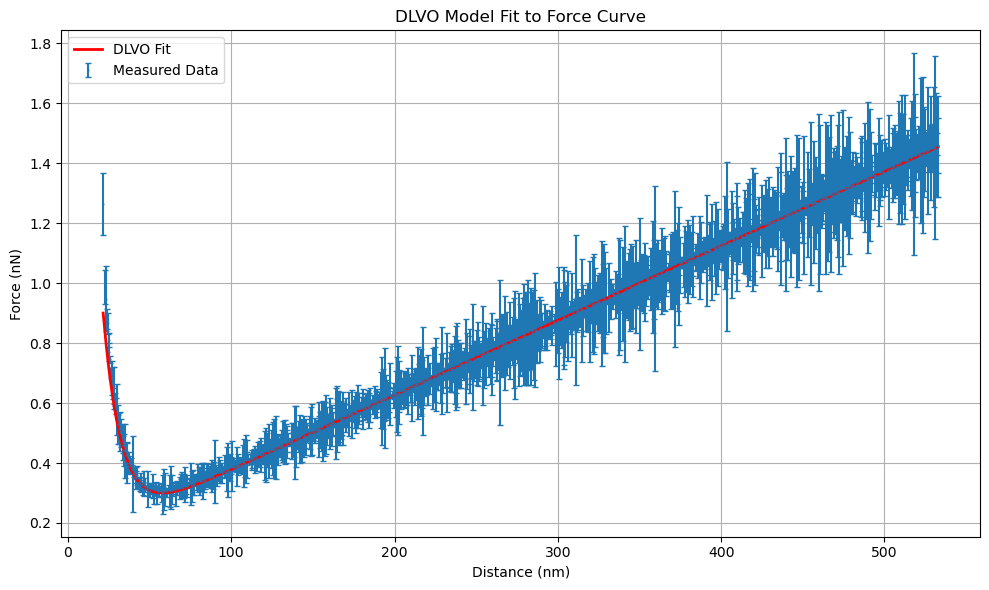

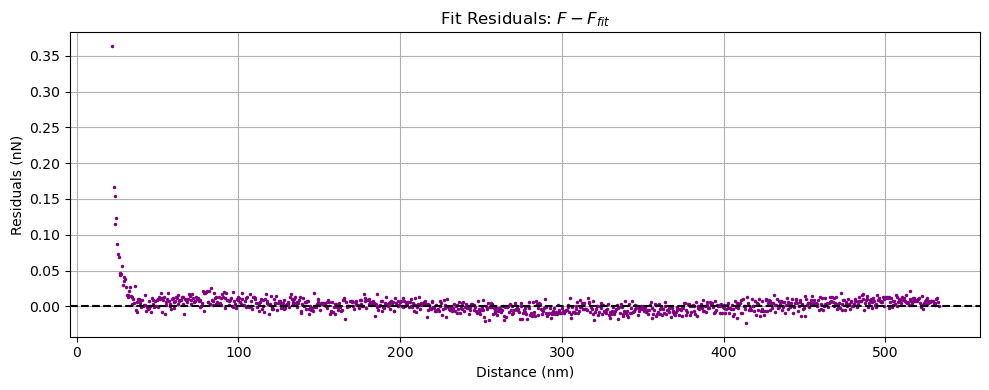

In [24]:
plt.figure(figsize=(10, 6))
plt.errorbar(d, f, yerr=df["ForceError_nN"], fmt='o', markersize=0.5, capsize=2, label='Measured Data')
plt.plot(d, f_fit, color='red', linewidth=2, label='DLVO Fit')
plt.xlabel('Distance (nm)')
plt.ylabel('Force (nN)')
plt.title('DLVO Model Fit to Force Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the residuals (difference between measured and fit)
plt.figure(figsize=(10, 4))
plt.plot(d, residuals, '.', markersize=3, color='purple')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Distance (nm)')
plt.ylabel('Residuals (nN)')
plt.title('Fit Residuals: $F - F_{fit}$')
plt.grid(True)
plt.tight_layout()
plt.show()

### Step 6: Estimating Ionic Strength $I$ from Fitted Debye Length $\lambda_D$

From DLVO theory, the relationship between Debye length $\lambda_D$ and the ionic strength $I$ of a monovalent salt solution (e.g., NaCl) is:

$$
\lambda_D \, (\text{nm}) = \frac{0.304}{\sqrt{I \, (\text{mol/L})}}
$$

This can be rearranged to solve for $I$:

$$
I = \left( \frac{0.304}{\lambda_D} \right)^2
$$

To include uncertainty, we propagate the error from the Debye length $\lambda_D$:

$$
\sigma_I = \left| \frac{dI}{d\lambda_D} \right| \cdot \sigma_{\lambda_D} = \left| \frac{-2 \cdot 0.304^2}{\lambda_D^3} \right| \cdot \sigma_{\lambda_D}
$$

This gives us the estimated ionic strength and its error in mol/L.


In [23]:
lD = 11.0546       # Debye length in nanometers
lD_err = 0.1539    # Error in Debye length

# Calculate ionic strength
I = (0.304 / lD) ** 2

# Propagate uncertainty
# Derivative of I with respect to lambda_D:
dI_dlambda = -2 * (0.304 ** 2) / (lD ** 3)
I_err = abs(dI_dlambda) * lD_err

print(f"Estimated Ionic Strength: {I:.6f} mol/L")
print(f"Uncertainty: ±{I_err:.6f} mol/L")


Estimated Ionic Strength: 0.000756 mol/L
Uncertainty: ±0.000021 mol/L
